# 2. Unsupervised Learning - Outlier Detection
Warren Liu

Winter 2023

University of Washington Bothell

CSS581: Machine Learning

Final Project

## 2.1 Import data

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist, squareform
import hdbscan

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import confusion_matrix

data = pd.read_csv('../data/card_transdata.csv')
scaler = StandardScaler()
for column in ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']:
    data[column] = scaler.fit_transform(data[[column]])

In [5]:
y = data['fraud']
x = data.drop(['fraud'], axis=1)

## 2.2 Clustering - HDBSCAN

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train = x_train[y_train == 0.0]

### Build the model

In [7]:
hdbscan_model = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=100)
hdbscan_model.allow_single_cluster = True
hdbscan_model.fit(x)

HDBSCAN(allow_single_cluster=True, min_cluster_size=100, min_samples=10)

### Calculate the confusion matrix manually

True positives: 23102
False positives: 64301
True negatives: 879929
False negatives: 32668
Precision: 0.26431587016463964
Recall: 0.4142370450062758
F1-score: 0.3227144782885041


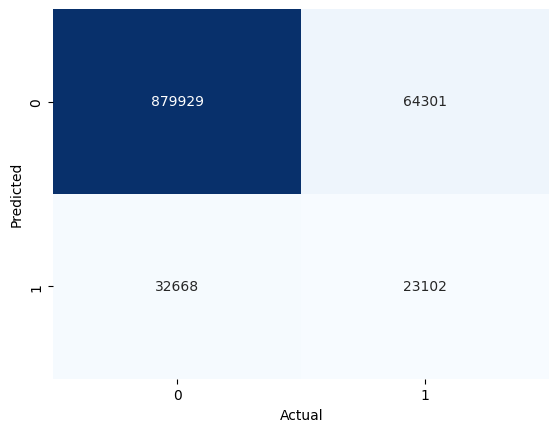

In [8]:
labels = hdbscan_model.labels_
true_labels = y

tp = sum((true_labels == 1) & (labels == -1))
fp = sum((true_labels == 1) & (labels > -1))
tn = sum((true_labels == 0) & (labels > -1))
fn = sum((true_labels == 0) & (labels == -1))

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

print("True positives:", tp)
print("False positives:", fp)
print("True negatives:", tn)
print("False negatives:", fn)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

labels = ['TP', 'FP', 'FN', 'TN']
values = [[tn, fp], [fn, tp]]
ax = sns.heatmap(pd.DataFrame(values, columns=['0', '1']), annot=True, fmt='d', cmap='Blues', cbar=False)
ax.set(xlabel='Actual', ylabel='Predicted')
plt.show()

### Set the labels

In [9]:
pred_labels = hdbscan_model.labels_
for label in pred_labels:
    if label == -1: label = 1
    else: label = 0

### Plot 10% of the result
This plot will look different every time you run it. It is a random projection of the data. But they should be clustered in the same way and look similar.

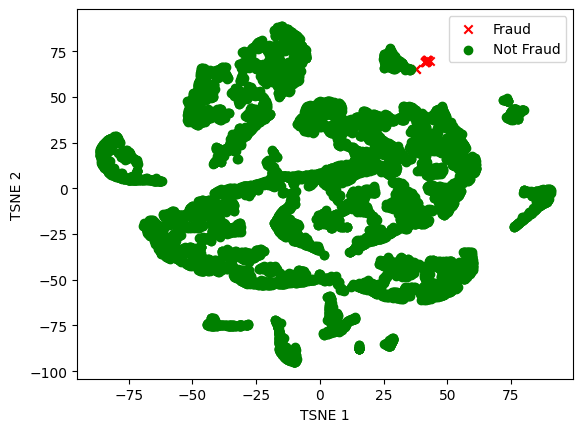

In [10]:
x = data.drop('fraud', axis=1)[:10000]
pred_labels = hdbscan_model.labels_[:10000]

x_dist = squareform(pdist(x, metric='cosine'))
tsne = TSNE(metric='precomputed', init='random')
x_2d = tsne.fit_transform(x_dist)

for i, label in enumerate(pred_labels):
    if label == 1:
        plt.scatter(x_2d[i, 0], x_2d[i, 1], c='r', marker='x', label='Fraud')
    else:
        plt.scatter(x_2d[i, 0], x_2d[i, 1], c='g', marker='o', label='Not Fraud')
# plt.scatter(x_2d[:, 0], x_2d[:, 1], c=y, label=y, cmap='cool', marker='o')
plt.xlabel('TSNE 1')
plt.ylabel('TSNE 2')
plt.legend(handles=[
    plt.scatter([], [], c='r', marker='x', label='Fraud'), 
    plt.scatter([], [], c='g', marker='o', label='Not Fraud')
])
plt.show()

## 2.3 Set Threshold for HDBSCAN

### Take a look at some scores of fraud data and normal data

In [11]:
scores = hdbscan_model.outlier_scores_
print('Fraud scores:')
print(scores[13], scores[24], scores[29], scores[35], scores[36])
print('Normal scores:')
print(scores[:12])

Fraud scores:
0.555059971591946 0.44014053067329423 0.40626726443531735 0.04595142859223266 0.03390924399178192
Normal scores:
[0.21171005 0.05952594 0.03247359 0.09160829 0.31261343 0.06753494
 0.00310516 0.37235055 0.19193927 0.00973783 0.0281041  0.03140715]


### Take a look at the distribution of scores

In [12]:
true_positive_index = [i for i in range(len(y)) if y[i] == 1]
print('Mean:', scores[true_positive_index].mean())
print('Min:', scores[true_positive_index].min())
print('Max:', scores[true_positive_index].max())
print('Std:', scores[true_positive_index].std())

Mean: 0.25225058784764626
Min: 0.0
Max: 0.9925615864030334
Std: 0.23806326889358118


### Threshold
Select the mean of mean and std as the threshold, and calculate confusion matrix manully.

True positives: 34999
False positives: 52404
True negatives: 728217
False negatives: 184380
Precision: 0.40043247943434435
Recall: 0.15953669220846114
F1-score: 0.22816853661557718


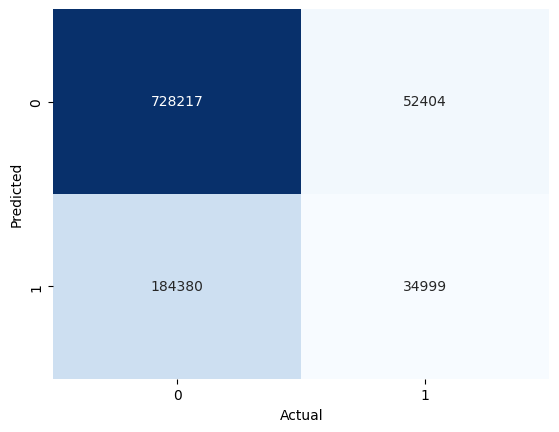

In [13]:
threshould = 0.245
labels_th = []

for score in scores:
    if score > threshould:
        labels_th.append(1)
    else:
        labels_th.append(0)

labels_th = pd.Series(labels_th)

tp = sum((true_labels == 1) & (labels_th == 1))
fp = sum((true_labels == 1) & (labels_th != 1))
tn = sum((true_labels == 0) & (labels_th == 0))
fn = sum((true_labels == 0) & (labels_th != 0))

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

print("True positives:", tp)
print("False positives:", fp)
print("True negatives:", tn)
print("False negatives:", fn)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

labels = ['TP', 'FP', 'FN', 'TN']
values = [[tn, fp], [fn, tp]]
ax = sns.heatmap(pd.DataFrame(values, columns=['0', '1']), annot=True, fmt='d', cmap='Blues', cbar=False)
ax.set(xlabel='Actual', ylabel='Predicted')
plt.show()

### Plot 10% of the result
This plot will look different every time you run it. It is a random projection of the data. But they should be clustered in the same way and look similar.

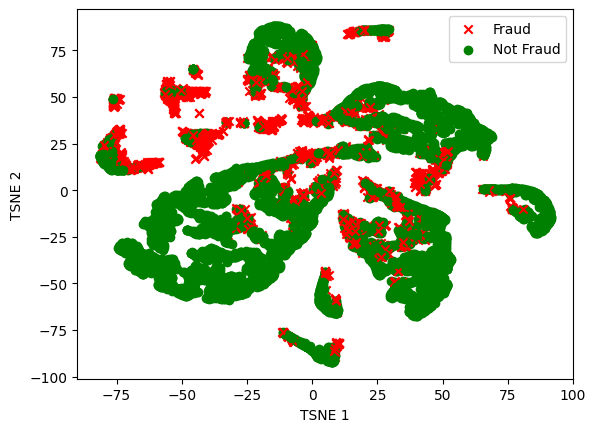

In [17]:
x = data.drop('fraud', axis=1)[:10000]
pred_labels = labels_th[:10000]

x_dist = squareform(pdist(x, metric='cosine'))
tsne = TSNE(metric='precomputed', init='random')
x_2d = tsne.fit_transform(x_dist)

for i, label in enumerate(pred_labels):
    if label == 1:
        plt.scatter(x_2d[i, 0], x_2d[i, 1], c='r', marker='x', label='Fraud')
    else:
        plt.scatter(x_2d[i, 0], x_2d[i, 1], c='g', marker='o', label='Not Fraud')
# plt.scatter(x_2d[:, 0], x_2d[:, 1], c=y, label=y, cmap='cool', marker='o')
plt.xlabel('TSNE 1')
plt.ylabel('TSNE 2')
plt.legend(handles=[
    plt.scatter([], [], c='r', marker='x', label='Fraud'), 
    plt.scatter([], [], c='g', marker='o', label='Not Fraud')
])
plt.show()

## 2.4 Using PCA to reduce dimension before fitting HDBSCAN

Warning: This will take a very long time to run.

In [ ]:
pca = PCA(n_components=3)
x = pca.fit_transform(data.drop(columns=['fraud']))

hdbscan_model = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=100)
hdbscan_model.allow_single_cluster = True
hdbscan_model.fit(x)

### Calculate the confusion matrix manually

In [ ]:
labels = hdbscan_model.labels_
true_labels = y

tp = sum((true_labels == 1) & (labels == -1))
fp = sum((true_labels == 1) & (labels > -1))
tn = sum((true_labels == 0) & (labels > -1))
fn = sum((true_labels == 0) & (labels == -1))

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

print("True positives:", tp)
print("False positives:", fp)
print("True negatives:", tn)
print("False negatives:", fn)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)


labels = ['TP', 'FP', 'FN', 'TN']
values = [[tn, fp], [fn, tp]]
ax = sns.heatmap(pd.DataFrame(values, columns=['0', '1']), annot=True, fmt='d', cmap='Blues', cbar=False)
ax.set(xlabel='Actual', ylabel='Predicted')
plt.show()

## 2.5 LOF (Local Outlier Factor)

### Search for best parameters
Not sure about the reason, but GridSearchCV works very slow, so used loop to search for best parameters.

In [19]:
# Uncomment to run

# import time
# true_labels = y

# best_n = None
# best_fp = None
# best_c = None

# for n in range(5, 35, 5):
#     for c in [0.05, 0.1, 0.25, 0.5]:
#         print("n:", n, "c:", c, end=" ")
#         start = time.time()
#         clf = LocalOutlierFactor(n_neighbors=5, contamination=c, n_jobs=-1)
#         end = time.time()
#         y_pred = clf.fit_predict(x)

#         tp = sum((true_labels == 1) & (y_pred == -1))
#         fp = sum((true_labels == 1) & (y_pred == 1))

#         if best_fp is None or fp < best_fp:
#             best_fp = fp
#             best_n = n
#             best_c = c
        
#         print("time:", end - start)

# print("Best n:", best_n)
# print("Best c:", best_c)
# print("Best false positives:", best_fp)

### Build the model with best parameters

In [20]:
clf = LocalOutlierFactor(n_neighbors=5, contamination=0.5, n_jobs=-1)
y_pred = clf.fit_predict(x)
y_pred

array([-1, -1, -1, ...,  1,  1,  1])

In [21]:
unique, counts = np.unique(y_pred, return_counts=True)
unique, counts

(array([-1,  1]), array([500000, 500000], dtype=int64))

### Calculate the confusion matrix manually

True positives: 47637
False positives: 39766
True negatives: 460234
False negatives: 452363
Precision: 0.5450270585677837
Recall: 0.095274
F1-score: 0.1621952901159851


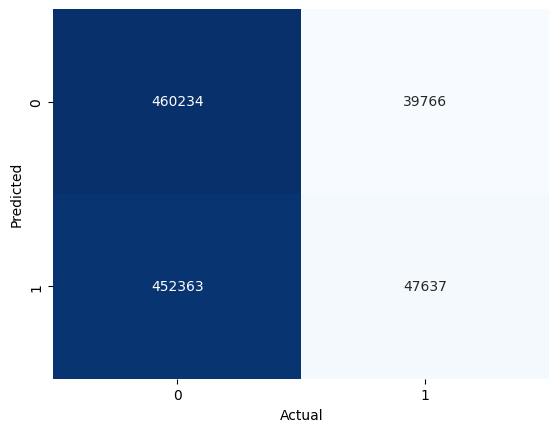

In [22]:
true_labels = y

tp = sum((true_labels == 1) & (y_pred == -1))
fp = sum((true_labels == 1) & (y_pred == 1))
tn = sum((true_labels == 0) & (y_pred == 1))
fn = sum((true_labels == 0) & (y_pred == -1))

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

print("True positives:", tp)
print("False positives:", fp)
print("True negatives:", tn)
print("False negatives:", fn)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)


labels = ['TP', 'FP', 'FN', 'TN']
values = [[tn, fp], [fn, tp]]
ax = sns.heatmap(pd.DataFrame(values, columns=['0', '1']), annot=True, fmt='d', cmap='Blues', cbar=False)
ax.set(xlabel='Actual', ylabel='Predicted')
plt.show()

## 2.6 Autoencoder Neural Network

### Need Tensorflow to run this part

In [23]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

tf.config.list_physical_devices('GPU')

[]

In [24]:
y = data['fraud']
x = data.drop(['fraud'], axis=1)

# Splite train set and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Since in this case, we only want to detect fraud, we will only use the normal data to train the autoencoder
print(f'x_train before: {x_train.shape}')
x_train = x_train[y_train == 0.0]
print(f'x_train after: {x_train.shape}')

print(f'y_train before: {y_train.shape}')
y_train = y_train[y_train == 0.0]
print(f'y_train after: {y_train.shape}')

x_train before: (800000, 7)
x_train after: (730040, 7)
y_train before: (800000,)
y_train after: (730040,)


### Model 1

In [25]:
# Build the Autoencoder Neural Network
input_layer = Input(shape=(7,))
encoder = Dense(5, activation="tanh", activity_regularizer=regularizers.l2(10e-5))(input_layer)
encoder = Dense(3, activation="relu")(encoder)
decoder = Dense(5, activation="relu")(encoder)
decoder = Dense(7, activation="tanh")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7)]               0         
                                                                 
 dense (Dense)               (None, 5)                 40        
                                                                 
 dense_1 (Dense)             (None, 3)                 18        
                                                                 
 dense_2 (Dense)             (None, 5)                 20        
                                                                 
 dense_3 (Dense)             (None, 7)                 42        
                                                                 
Total params: 120
Trainable params: 120
Non-trainable params: 0
_________________________________________________________________


In [26]:
# Compile the model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with only normal data
autoencoder.fit(x_train, x_train, epochs=30, batch_size=64, shuffle=True)

Epoch 1/30
11407/11407 [==============================] - 13s 1ms/step - loss: 0.2512
Epoch 2/30
11407/11407 [==============================] - 12s 1ms/step - loss: 0.2149
Epoch 3/30
11407/11407 [==============================] - 12s 1ms/step - loss: 0.2133
Epoch 4/30
11407/11407 [==============================] - 12s 1ms/step - loss: 0.2127
Epoch 5/30
11407/11407 [==============================] - 12s 1ms/step - loss: 0.2123
Epoch 6/30
11407/11407 [==============================] - 12s 1ms/step - loss: 0.2089
Epoch 7/30
11407/11407 [==============================] - 12s 1ms/step - loss: 0.2058
Epoch 8/30
11407/11407 [==============================] - 12s 1ms/step - loss: 0.2053
Epoch 9/30
11407/11407 [==============================] - 12s 1ms/step - loss: 0.2052
Epoch 10/30
11407/11407 [==============================] - 12s 1ms/step - loss: 0.2051
Epoch 11/30
11407/11407 [==============================] - 12s 1ms/step - loss: 0.2050
Epoch 12/30
11407/11407 [===========================

In [27]:
# Reconstruction accuracy
rec_error = autoencoder.evaluate(x_test, x_test)
acc = 1 - rec_error
print(f'Reconstruction Accuracy: {acc}')

6250/6250 [==============================] - 5s 842us/step - loss: 0.2874
Reconstruction Accuracy: 0.7126139402389526


In [28]:
# Predict the test data
y_pred = autoencoder.predict(x_test)

# Calculate the MSE
mse = np.mean(np.power(x_test - y_pred, 2), axis=1)
print(mse)

# Calculate the threshold
threshold = np.quantile(mse, 0.99)
print(f'Threshold: {threshold}')

6250/6250 [==============================] - 5s 790us/step
987231    0.001467
79954     0.005539
567130    0.002717
500891    0.856638
55399     0.002030
            ...   
90245     0.137025
639296    0.003342
311939    0.504951
324459    0.001383
390499    0.102233
Length: 200000, dtype: float64
Threshold: 3.692687951940871


[1012, 988, 16431, 181569]


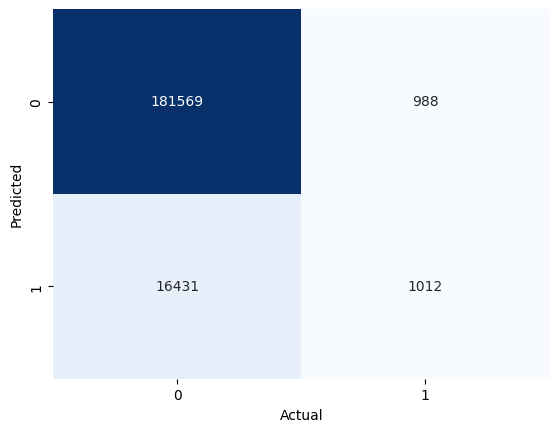

In [29]:
# Find the data that is above the threshold, which is predicted as fraud
y_pred = np.where(mse > threshold, 1, 0)

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

labels = ['TP', 'FP', 'FN', 'TN']
values = [tp, fp, fn, tn]

print(values)

ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
ax.set(xlabel='Actual', ylabel='Predicted')
plt.show()

### Model 2

In [30]:
# Build the Autoencoder Neural Network
input_layer = Input(shape=(7,))
encoder = Dense(5, activation="tanh", activity_regularizer=regularizers.l2(10e-5))(input_layer)
encoder = Dropout(0.2)(encoder)
encoder = Dense(3, activation="relu")(encoder)
decoder = Dropout(0.2)(encoder)
decoder = Dense(5, activation="relu")(encoder)
decoder = Dense(7, activation="tanh")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 7)]               0         
                                                                 
 dense_4 (Dense)             (None, 5)                 40        
                                                                 
 dropout (Dropout)           (None, 5)                 0         
                                                                 
 dense_5 (Dense)             (None, 3)                 18        
                                                                 
 dense_6 (Dense)             (None, 5)                 20        
                                                                 
 dense_7 (Dense)             (None, 7)                 42        
                                                                 
Total params: 120
Trainable params: 120
Non-trainable param

In [31]:
# Compile the model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
# Train the model with only normal data
autoencoder.fit(x_train, x_train, epochs=30, batch_size=64, shuffle=True)

Epoch 1/30
11407/11407 [==============================] - 13s 1ms/step - loss: 0.2694
Epoch 2/30
11407/11407 [==============================] - 13s 1ms/step - loss: 0.2517
Epoch 3/30
11407/11407 [==============================] - 12s 1ms/step - loss: 0.2513
Epoch 4/30
11407/11407 [==============================] - 13s 1ms/step - loss: 0.2510
Epoch 5/30
11407/11407 [==============================] - 13s 1ms/step - loss: 0.2508
Epoch 6/30
11407/11407 [==============================] - 12s 1ms/step - loss: 0.2507
Epoch 7/30
11407/11407 [==============================] - 13s 1ms/step - loss: 0.2510
Epoch 8/30
11407/11407 [==============================] - 13s 1ms/step - loss: 0.2507
Epoch 9/30
11407/11407 [==============================] - 13s 1ms/step - loss: 0.2506
Epoch 10/30
11407/11407 [==============================] - 12s 1ms/step - loss: 0.2505
Epoch 11/30
11407/11407 [==============================] - 13s 1ms/step - loss: 0.2500
Epoch 12/30
11407/11407 [===========================

In [32]:
# Predict the test data
y_pred = autoencoder.predict(x_test)

# Calculate the MSE
mse = np.mean(np.power(x_test - y_pred, 2), axis=1)
print(mse)

# Calculate the threshold
threshold = np.quantile(mse, 0.99)
print(f'Threshold: {threshold}')

6250/6250 [==============================] - 5s 784us/step
987231    0.013006
79954     0.073188
567130    0.025418
500891    1.018335
55399     0.034176
            ...   
90245     0.174279
639296    0.008883
311939    0.745928
324459    0.034804
390499    0.221749
Length: 200000, dtype: float64
Threshold: 3.8859088083311923


In [33]:
# Reconstruction accuracy
rec_error = autoencoder.evaluate(x_test, x_test)
acc = 1 - rec_error
print(f'Reconstruction Accuracy: {acc}')

6250/6250 [==============================] - 5s 853us/step - loss: 0.3340
Reconstruction Accuracy: 0.6659594476222992


[1008, 992, 16435, 181565]


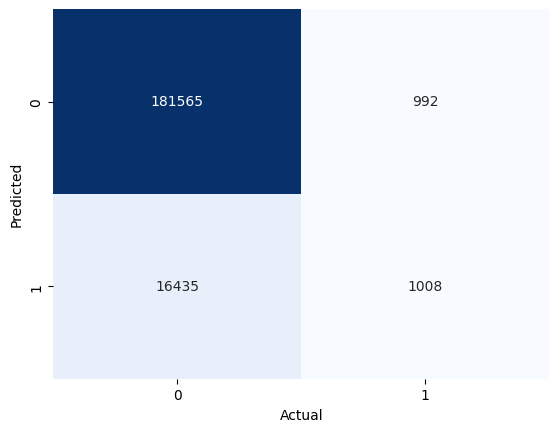

In [34]:
# Find the data that is above the threshold, which is predicted as fraud
y_pred = np.where(mse > threshold, 1, 0)

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

labels = ['TP', 'FP', 'FN', 'TN']
values = [tp, fp, fn, tn]

print(values)

ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
ax.set(xlabel='Actual', ylabel='Predicted')
plt.show()